# Face Analysis with Supervised and Unsupervised Neural Networks

Here we'll examine a couple hundred thousand images of faces from IMDB and Wikipedia to see if we can:

    1. Predict the age of the person,
    2. Create an attention map to visualize internal layers of a convolutional neural network, and
    3. Cluster the images based on encoded versions to see what differences an unsupervised algorithm finds. 

Ultimately, we'll have more success with parts 2 and 3, as predicting age with a supervised neural network proves to be a very difficult task.

In [ ]:
import numpy as np
import pandas as pd
import scipy, scipy.io
import matplotlib.pyplot as plt
import datetime
import cv2
import pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.cluster import KMeans

import tensorflow as tf

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


# Data Preparation

We'll load in the data, and see what we've got. The dataset is from here: https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/. The data has been preprocessed to select just the portion of the image which is around the face. This should save us substantial effort on the front end, and give our images much more uniformity.

## Load the Data

The metadata is in a .mat file, so we'll have some funky formatting to take care of.

In [4]:
# In case you've already saved variables and want to skip all the processing.
df_all = pd.read_pickle('df_all.pkl')

In [7]:
# Convert the metadata MAT file. Due to unweildy formatting, this is easiest by to do by hand.
data_path = '/data/'

# Load the MAT
dat_wiki = scipy.io.loadmat(data_path + 'wiki_crop/wiki.mat')
dat_imdb = scipy.io.loadmat(data_path + 'imdb_crop/imdb.mat')

# For reference, data => dat_wiki, data_path => '/data/wiki_crop', name_str => 'wiki'

def make_df(data, data_path, name_str):
    
    # Create the dataframe. Indices are the sum of the lengths of the two data sources.
    df = pd.DataFrame(index=range(len(data[name_str][0][0][1][0])), 
        columns=['dob', 'photo_yr', 'age', 'file_path', 'gender', 
                           'name', 'face_loc', 'face_score', 'second_face'],
        data=0)

    # Load in individual rows. DOB Comes in ordinal format.
    df.dob = [datetime.date.fromordinal(x).year for x in data[name_str][0][0][0][0]]
    df.photo_yr = data[name_str][0][0][1][0]
    df.age = df.photo_yr - df.dob
    df.file_path = [data_path + x[0] for x in data[name_str][0][0][2][0]]
    df.gender = data[name_str][0][0][3][0]
    df.name = data[name_str][0][0][4][0]
    df.face_loc = [x[0] for x in data[name_str][0][0][5][0]]
    df.face_score = data[name_str][0][0][6][0]
    df.second_face = data[name_str][0][0][7][0]
    
    return df

# Merge and display results.
df_wiki = make_df(dat_wiki, '/data/wiki_crop/', 'wiki')
df_imdb = make_df(dat_imdb, '/data/imdb_crop/', 'imdb')
df_all = pd.concat([df_wiki, df_imdb]).reset_index(drop=True)

df_all.head()

dob  photo_yr  age                                        file_path  \
0  1982      2009   27  /data/wiki_crop/17/10000217_1981-05-05_2009.jpg   
1  1926      1964   38  /data/wiki_crop/48/10000548_1925-04-04_1964.jpg   
2  1949      2008   59    /data/wiki_crop/12/100012_1948-07-03_2008.jpg   
3  1931      1961   30  /data/wiki_crop/65/10001965_1930-05-23_1961.jpg   
4  1972      2012   40  /data/wiki_crop/16/10002116_1971-05-31_2012.jpg   

   gender                    name  \
0     1.0       [Sami Jauhojärvi]   
1     1.0        [Dettmar Cramer]   
2     1.0           [Marc Okrand]   
3     1.0  [Aleksandar Matanović]   
4     0.0          [Diana Damrau]   

                                            face_loc  face_score  second_face  
0  [111.291094733, 111.291094733, 252.669930818, ...    4.300962          NaN  
1  [252.483302295, 126.681651148, 354.531925962, ...    2.645639     1.949248  
2                    [113.52, 169.84, 366.08, 422.4]    4.329329          NaN  
3                                   [1, 1, 634, 440]        -inf          NaN  
4  [171.610314052, 75.5745123976, 266.766115706, ...    3.408442          NaN

## Examine the Data

Let's see what we've got!

In [8]:
# Any missing data?
df_all.isnull().sum()

dob                 0
photo_yr            0
age                 0
file_path           0
gender          11105
name                0
face_loc            0
face_score          0
second_face    305158
dtype: int64

That's a good starting point. At some point later on we may need to exclude the NaN gender results, but that should be fine for predicting Age. The 'second_face' feature is interesting. Per the documentation, NaN values are when no second face is present. Having two faces in an image could cause some problems, so let's use only those examples that have NO second face.

In [9]:
# Drop all examples where 'second_face' is not null.
df_all = df_all.drop(df_all[~df_all.second_face.isnull()].index).reset_index(drop=True)
print(df_all.shape)

(305158, 9)


Because we're using the pre-cropped images, we won't have to worry about 'face_loc', which gives coordinates for where the face is in the image. We are interested in 'face_score', however, as it tells us how easily identifiable the face was in the image. Let's look at a few different values and see if we should remove images below some threshold.

In [10]:
df_all.face_score.describe()

count    3.051580e+05
mean             -inf
std               NaN
min              -inf
25%              -inf
50%      2.332299e+00
75%      3.774737e+00
max      7.381689e+00
Name: face_score, dtype: float64

Values of '-inf' have no face present. Let's look at some of those, plus some with values near 0.8, 1.5, and 3.0. There are no face values below 0.7 except the -inf values, so the 0.8 group will be examples of the 'worst' face identification.

In [11]:
# Grab file names fitting each face_score range.
files_no_face = df_all[df_all.face_score < 0].sample(3, random_state=99).file_path
files_low_face = df_all[(df_all.face_score > 0) & (df_all.face_score < 0.8)].sample(3, random_state=99).file_path
files_med_face = df_all[(df_all.face_score > 1.4) & (df_all.face_score < 1.6)].sample(3, random_state=99).file_path
files_high_face = df_all[(df_all.face_score > 2.9) & (df_all.face_score < 3.1)].sample(3, random_state=99).file_path

# Use cv2 to grab the images.
im_no_face = [cv2.imread(x) for x in files_no_face]
im_low_face = [cv2.imread(x) for x in files_low_face]
im_med_face = [cv2.imread(x) for x in files_med_face]
im_high_face = [cv2.imread(x) for x in files_high_face]

In [34]:
# A function to plot three images in a row. Because we imported from cv2 and are displaying with plt, 
# we need to reverse the channels by using [:,:,::-1]. This converts BGR to RGB.

def plot_three(im_list):
    plt.figure(figsize=(14,4))
    for i, array in enumerate(im_list):
        plt.subplot(1, len(im_list), i+1)
        plt.imshow(array[:,:,::-1])
        plt.axis('off')
    plt.show()

# Same, but with nine images.

def plot_nine(im_list):
    plt.figure(figsize=(14,14))
    for i, array in enumerate(im_list):
        plt.subplot(3, 3, i+1)
        plt.imshow(array[:,:,::-1])
        plt.axis('off')
    plt.show()

face_score of -inf:


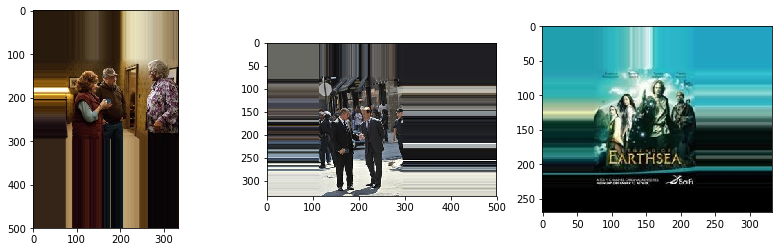

In [12]:
# Let's see the images with -inf face_score.
print('face_score of -inf:')
plot_three(im_no_face)

Yup -- none of those have faces. We'll have to remove all of them.

face_score below 0.8:


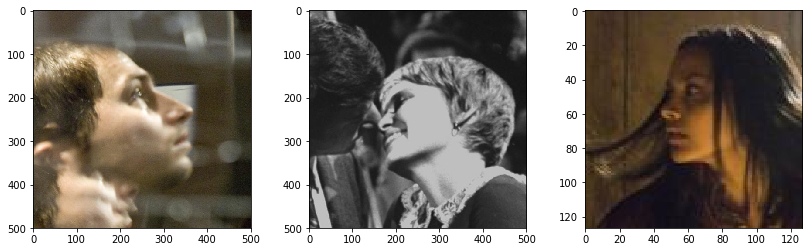

face_score near 1.5:


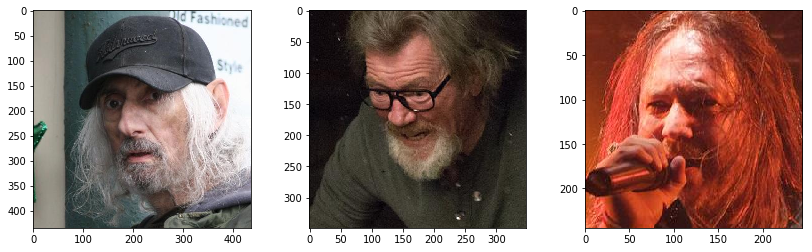

face_score near 3.0:


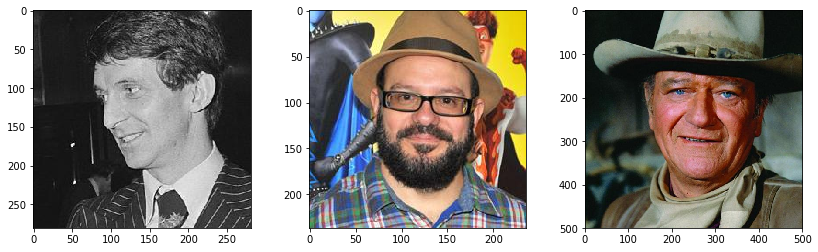

In [13]:
# Now the rest
print('face_score below 0.8:')
plot_three(im_low_face)
print('face_score near 1.5:')
plot_three(im_med_face)
print('face_score near 3.0:')
plot_three(im_high_face)

All those seem fine. We can include all the examples except those with '-inf' face_score.

In [14]:
# Drop elements with negative face_score.
df_all = df_all.drop(df_all[df_all.face_score<0].index).reset_index(drop=True)
print(df_all.shape)

(224840, 9)


Well, we've had to eliminate a large portion of our dataset, but those images were not going to help with our model. Since we're curious about age, let's take a look at its distribution.

In [15]:
print(df_all.age.describe())
print('Below 15:', df_all[df_all.age < 15].shape[0])
print('Above 65:', df_all[df_all.age > 65].shape[0])

count    224840.000000
mean         36.742742
std          34.323033
min         -40.000000
25%          26.000000
50%          34.000000
75%          44.000000
max        2014.000000
Name: age, dtype: float64
Below 15: 5268
Above 65: 8505


Oops -- we've got some bad values in here. We also have too few examples below 15 or over 65. As we'll see, we're going to have to resample the data to balance our age groups, and leaving in age groups with too few examples will cause many duplicates to be made. Let's remove the extreme values.

In [16]:
# Drop age outliers.
print('Age outliers:', len(df_all[(df_all.age <= 15) | (df_all.age > 65)]))
df_all = df_all.drop(df_all[(df_all.age <= 15) | (df_all.age > 65)].index).reset_index(drop=True)
print('New shape:', df_all.shape)

Age outliers: 14991
New shape: (209849, 9)


And the distribution of the remaining ages?

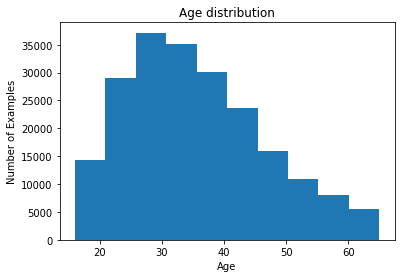

In [17]:
# Plot the distribution of ages.
plt.hist(df_all.age, bins=10)
plt.xlabel('Age')
plt.ylabel('Number of Examples')
plt.title('Age distribution')
plt.show()

We'll have to resample the data to balance the ages, but we'll only do it on the training set, after the data is split.

## Drop Small Images

One final step before we split the data: we have to get rid of the small images in our dataset. Some of them are only 1x1 pixel! I hesitate to load in all the images just to get their sizes, but it actually goes pretty quickly, and it will be valuable to have the original dimensions stored in the dataframe. Let's visualize the dimension distribution of our images.

In [4]:
# Function to create x_dim and y_dim features in our df, load each image and populate that data.

def get_x_y_dims(df):

    # Create our new features
    df['x_dim'] = 0
    df['y_dim'] = 0

    # Iterate over the rows to grab the image size.
    for index in df.index:
        image = cv2.imread(df.loc[index, 'file_path'])
        df.loc[index, 'x_dim'] = image.shape[0]
        df.loc[index, 'y_dim'] = image.shape[1]
        
        if index % 5000 == 0:
            print(index)
        
    return df

In [ ]:
df_all = get_x_y_dims(df_all)
print(df_all.columns)

Index(['dob', 'photo_yr', 'age', 'file_path', 'gender', 'name', 'face_loc',
       'face_score', 'second_face', 'x_dim', 'y_dim'],
      dtype='object')


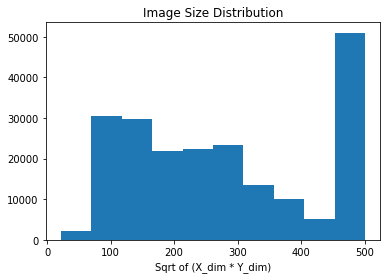

Number of small images: 13992


In [21]:
plt.hist(np.sqrt(np.multiply(df_all.x_dim, df_all.y_dim)))
plt.xlabel('Sqrt of (X_dim * Y_dim)')
plt.title('Image Size Distribution')
plt.show()

print('Number of small images:', df_all[(df_all.x_dim < 90) | (df_all.y_dim < 90)].shape[0])

We have a lot of images right around 200x200 pixels. We want to avoid upsizing too many of our images, but we also want to keep as high resolution as possible (even though that will increase processing time). Only about 3% of our remaining images are below 90x90 pixels, so I'm going to go ahead and drop those images and rescale everything else to 150x150 pixels. This is a judgment call, but it seems like a good balance based on the data we're dealing with. We'll do the actual image resize during the batch process later on.

In [5]:
def drop_small_images(df, dim_size):
    # Drop small images where either dimension is below the threshold.
    df = df.drop(df[(df.x_dim < dim_size) | (df.y_dim < dim_size)].index).reset_index(drop=True)
    return df

In [24]:
#Drop the small images.
df_all = drop_small_images(df_all, 90)

print('New shape:', df_all.shape)

New shape: (195857, 11)


In [29]:
# Let's just save this so we can skip all the processing in the future.
df_all.to_pickle('df_all.pkl')

## Splitting the Data

We'll split our data into training, validation, and test sets. We won't touch the test set until everything is tuned up and finalized. At this point I would like to process and normalize the data, however, those arrays take up too much memory, so we'll do processing in the batch step.

In [6]:
df_all.head()

dob  photo_yr  age                                        file_path  \
0  1982      2009   27  /data/wiki_crop/17/10000217_1981-05-05_2009.jpg   
1  1949      2008   59    /data/wiki_crop/12/100012_1948-07-03_2008.jpg   
2  1972      2012   40  /data/wiki_crop/16/10002116_1971-05-31_2012.jpg   
3  1961      2012   51  /data/wiki_crop/02/10002702_1960-11-09_2012.jpg   
4  1938      1971   33  /data/wiki_crop/41/10003541_1937-09-27_1971.jpg   

   gender                name  \
0     1.0   [Sami Jauhojärvi]   
1     1.0       [Marc Okrand]   
2     0.0      [Diana Damrau]   
3     0.0    [Krista Tippett]   
4     1.0  [Bernie Whitebear]   

                                            face_loc  face_score  second_face  \
0  [111.291094733, 111.291094733, 252.669930818, ...    4.300962          NaN   
1                    [113.52, 169.84, 366.08, 422.4]    4.329329          NaN   
2  [171.610314052, 75.5745123976, 266.766115706, ...    3.408442          NaN   
3  [274.765632403, 57.7700900839, 376.886994554, ...    4.748056          NaN   
4  [79.3558018869, 26.6599339623, 197.609504717, ...    4.184828          NaN   

   x_dim  y_dim  
0    257    257  
1    457    457  
2    173    173  
3    185    185  
4    215    214

In [6]:
# Split the data to get the test set, then split it again to get the val set.
df_train, df_test = train_test_split(df_all, test_size=10000, random_state=50)
df_train, df_val = train_test_split(df_train, test_size=10000, random_state=50)

# Reset indices will allow us to call back to our train/val/test dataframes without confusion.
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print('Training size:', df_train.shape)
print('Validation size:', df_val.shape)
print('Testing size:', df_test.shape)

Training size: (175857, 11)
Validation size: (10000, 11)
Testing size: (10000, 11)


## Resample the Training Set

As mentioned before, we'd like to have a balance of ages in our training set.

In [8]:
# Print how many examples we have in each 5-year bin.
for i in range(15, 61, 5):
    print('{}-{}:'.format(i+1, i+5), df_train[(df_train.age>i) & (df_train.age<=i+5)].shape[0])

16-20: 11679
21-25: 23944
26-30: 30997
31-35: 29282
36-40: 25238
41-45: 19958
46-50: 13646
51-55: 9375
56-60: 6906
61-65: 4832


We'd like to find a balance of retaining as much of the original data as possible without creating too many duplicates of the rare age groups. Let's bring them all to 18,000 for now.

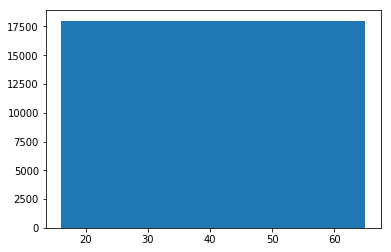

Final Training Size: (180000, 11)


In [7]:
# Create the new resampled dataframe.
df_train_resample = resample(df_train[(df_train.age>15) & (df_train.age<=20)], n_samples=18000)

# Concat with the remaining age groups.
for i in range(20, 61, 5):
    df_train_resample = pd.concat([df_train_resample, 
                                   resample(df_train[(df_train.age>i) & (df_train.age<=i+5)], n_samples=18000)])

# Shuffle and reset indices.
df_train_resample = df_train_resample.sample(frac=1).reset_index(drop=True)

plt.hist(df_train_resample.age, bins=10)
plt.show()

print('Final Training Size:', df_train_resample.shape)

In [8]:
# Everything all set?
df_train_resample.head()

dob  photo_yr  age                                          file_path  \
0  1965      2000   35  /data/imdb_crop/44/nm1798644_rm694980352_1964-...   
1  1954      2009   55  /data/imdb_crop/47/nm0000547_rm1818986752_1953...   
2  1979      2010   31  /data/imdb_crop/47/nm0197647_rm1247776512_1978...   
3  1969      2007   38  /data/imdb_crop/77/nm0005377_rm2719980288_1968...   
4  1956      2004   48     /data/wiki_crop/25/9760725_1955-12-20_2004.jpg   

   gender                name  \
0     NaN       [Tom Westman]   
1     1.0     [Alfred Molina]   
2     1.0  [James Badge Dale]   
3     1.0      [Sam Rockwell]   
4     1.0       [Rory Markas]   

                                            face_loc  face_score  second_face  \
0  [114.874180168, 114.874180168, 216.995542319, ...    2.445637          NaN   
1  [60.4641268988, 100.385544831, 239.528507595, ...    4.197151          NaN   
2  [99.1417736092, 99.1417736092, 225.188053964, ...    4.388761          NaN   
3  [18.8484649278, 55.4773947835, 183.144649278, ...    4.942608          NaN   
4  [204.652791654, 88.0763392802, 335.157300574, ...    3.977326          NaN   

   x_dim  y_dim  
0    185    185  
1    324    325  
2    229    229  
3    298    297  
4    237    237

## Image Preprocessing

For our model, we'll have to resize all our images and put them into a numpy array. We've gotten rid of all the bad images by using the face_score and removing small images. It would be nice to process with as large a standard image size as possible, without having to upsize too many images, as doing so may have adverse effects on our CNN. We're going to resize images to 150x150 pixels.

Here I'll create preprocessing functions and run them on a sample of the data, but we'll save running them in full until we're doing the modeling.

In [9]:
# Create our file array, load the images and resize them with cv2.

def process_images(df, final_shape=(150, 150)):
    # Set up array.
    X = []
    
    # Get each filename, read, resize, and append to X.
    for file in df.file_path:
        X.append(cv2.resize(cv2.imread(file), final_shape))
    
    # Normalize the array as a float.
    X = np.asarray(X)/255.
    
    # Y is just the age from the df.
    Y = np.array(df.age)
    
    return X, Y

In [10]:
df_sample = df_train_resample[:500]
X_sample, Y_sample = process_images(df_sample)
print('Final shape:', X_sample.shape, Y_sample.shape)

Final shape: (500, 150, 150, 3) (500,)


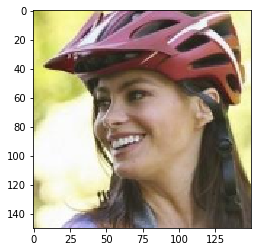

Age: 36


In [11]:
# Let's make sure it worked.
plt.imshow(X_sample[300][:,:,::-1])
plt.show()
print('Age:', Y_sample[300])

Great! 

# Modeling

We're going to need a function to break our data up into batches and run it through the model.

In [12]:
# The function will take our df and split it into batches of desired size.
# The result is meant to be fed item-wise into process_images() function.
# Example: 
#    for batch in get_batches(df):
#        model.fit(process_images(batch), 
#                  ...)
#
# This prevents processed images from taking over memory.

def get_batches(df, batch_size=10000):
    if len(df) < batch_size:
        return [df]
    
    n_batches = len(df) // batch_size

    # If batches fit exactly into the size of df.
    if len(df) % batch_size == 0:
        return [df[i*batch_size:(i+1)*batch_size] for i in range(n_batches)]
    
    # If there is a remainder.
    else:
        return [df[i*batch_size:min((i+1)*batch_size, len(df))] for i in range(n_batches+1)]

In [16]:
#Test our functions.
for batch in get_batches(df_sample, 500):
    X, Y = process_images(batch)

print(X.shape, Y.shape)

(500, 150, 150, 3) (500,)


Because of this makeshift method for processing images on-demand, we're going to have to run one epoch at a time. Let's make one more function to actually fit the model.

In [11]:
# Fit model using get_batches() and process_images().
#
# Inputs are: 
#
#      model -- model to train
#      df_train -- df to train, ready to be passed into get_batches.
#      df_val -- df to validate, ready to be passed into process_images.
#      epochs -- number of total epochs to run.
#      df_batch_size -- batch size to pass into get_batches. Larger values take more memory.
#      model_batch_size -- batch size passed into model.fit.
#      image_size -- image size passed into process_images.
#
#

def fit_model(model, df_train, df_val, epochs=10, df_batch_size=10000, model_batch_size=128, image_size=(150, 150)):
    
    print('Training on {} examples.'.format(len(df_train)))
    print('Validating on {} examples.'.format(len(df_val)))
    
    # We have to run epochs one at a time -- each epoch we'll evaluate the val set.
    for i in range(epochs):
        
        print('\nStarting Epoch {} of {}.'.format(i+1, epochs))
        
        # In each epoch, we'll run the model on each of the batches.
        for batch in get_batches(df_train, df_batch_size):
            X, Y = process_images(batch, image_size)
            model.fit(X, Y,
                      batch_size=model_batch_size,
                      epochs=1,
                      verbose=1)

        X_val, Y_val = process_images(df_val, image_size)
        score = model.evaluate(X_val, Y_val, verbose=1)
    
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return score

## Dense Neural Network

Before we try out a CNN for this dataset, let's see if we can do anything with a standard densely connected NN.

In [ ]:
# In case you've already saved the model
dense_model = load_model('dense_model.h5')

In [53]:
# Build the densely connected neural net. We'll just use dense and dropout for this one.

dense_model = Sequential()

dense_model.add(Flatten(input_shape=(150, 150, 3)))
dense_model.add(Dense(256, activation='relu'))
dense_model.add(Dropout(.1))
dense_model.add(Dense(128, activation='relu'))
dense_model.add(Dropout(.1))
dense_model.add(Dense(64, activation='relu'))
dense_model.add(Dropout(.1))
dense_model.add(Dense(1, activation='relu'))

dense_model.summary()

dense_model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               17280256  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
__________

In [ ]:
# Because our data arrays are so large, we'll run it with out batch processing function.

score = fit_model(dense_model, 
                  df_train_resample, 
                  df_val, 
                  epochs=3, 
                  df_batch_size=10000)

In [12]:
# A function to plot the results of the model on the validation and training sets. 

def plot_val_train(model, X_val, Y_val, X_train, Y_train):
    
    # Predict and fit validation data
    Y_pred_val = model.predict(X_val)
    fit_val = np.polyfit(Y_val, Y_pred_val, deg=1)
    
    # Predit and fit training data
    Y_pred_train = model.predict(X_train)
    fit_train = np.polyfit(Y_train, Y_pred_train, deg=1)
    
    # Make plot
    plt.figure(figsize=(10,4))
    
    # Plot Validation Data
    plt.subplot(1, 2, 1)
    plt.scatter(Y_val, Y_pred_val)
    plt.plot(Y_val, Y_val * fit_val[0] + fit_val[1], color='red')
    plt.plot(Y_val, Y_val, color='yellow')
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('Validation Data')
    
    plt.subplot(1, 2, 2)
    plt.scatter(Y_train, Y_pred_train)
    plt.plot(Y_train, Y_train * fit_train[0] + fit_train[1], color='red')
    plt.plot(Y_train, Y_train, color='yellow')
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('Training Data')    
    
    plt.show()

In [13]:
# We'll load our val and beginning of the training set into memory for convenience.
X_val, Y_val = process_images(df_val)
X_train_10k, Y_train_10k = process_images(df_train_resample[:10000])

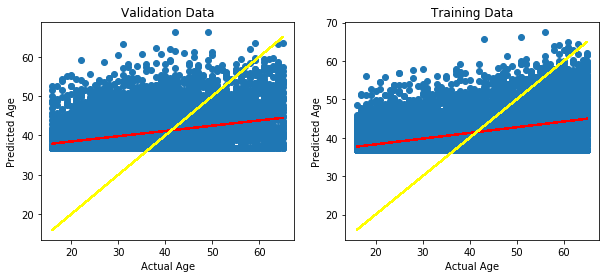

In [99]:
# Plot the results from the dense model.
plot_val_train(dense_model, X_val, Y_val, X_train_10k, Y_train_10k)

This model is terrible. The red line is the best fit through the predicted age values, the yellow line would be a perfect fit. Well, this is a good example of why we don't use dense networks for image tasks. Let's move on to CNN.

In [100]:
# Saves the model for later.
dense_model.save('dense_model.h5')

## Convolutional Neural Network

Okay -- our dense model is doing pretty much nothing... Let's try CNN. We'll use two convolutional layers, followed by dropout (to prevent over fitting) and a dense layer. This is a fairly standard CNN construction I've used similar architecture for other tasks, although perhaps not as challenging as age determination.

In [ ]:
# In case you have a saved version.
cnn_model = load_model('cnn_model.h5')

In [101]:
cnn_model = Sequential()

# First convolutional layer, note the specification of shape

cnn_model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(150, 150, 3)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.5))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(1, activation='linear'))

cnn_model.summary()

cnn_model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 73, 73, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 341056)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               43655296  
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
__________

In [ ]:
# Again, we'll have train on batches using our custom fit function.

score = fit_model(cnn_model, 
                  df_train_resample, 
                  df_val, 
                  epochs=3, 
                  df_batch_size=20000)

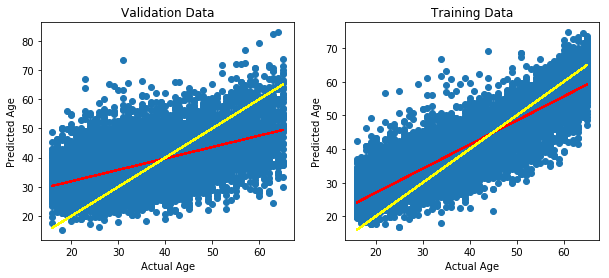

In [23]:
# How did it do? 
plot_val_train(cnn_model, X_val, Y_val, X_train_10k, Y_train_10k)

So, we're still not doing well. There is some indication of the trend going the right direction with the validation set, but not anywhere near as accurate as we'd need for any kind of public roll-out. It does appear that we're beginning to do better on the training set, however that is likely due to overfitting. We have a large number of trainable variables in our model, so we can overfit even a complicated training set.

It's unfortunate that we aren't able to do better here. It may be that age cues in images are extremely subtle, and that we would need higher definition images or a larger training set to start to identify the important features. For now let's move on to unsupervised learning, and see if we can learn more about our dataset or the models we're building.

In [24]:
# Save the model for later.
cnn_model.save('cnn_model.h5')

# Unsupervised Learning

Ultimately we'd like to cluster our images by some important defining features. The problem is that the original images themselves are too complicated to cluster effectively. Instead of clustering on the raw data, we'll build an autoencoder to downsample the images, pull out the encoded results, and cluster with those reduced-dimension images. 

This also connects nicely to the last topic we're focusing on, which is the attention map. An attention map will allow us to see which pixels are considered valuable by our model. This is one way of debugging a CNN, but also allows us to peer into what is typically the 'black box' of a neural network. This approach could be used for other kinds of neural networks as well to get a sense of why the model is making the decisions it is. Very cool.

## Autoencoder

An autoencoder works by scaling down an image (using convolutional and pooling layers), then scaling it back up using convolutional and upsampling layers, and using the same image arrays for both input and output.

I'll try out two separate models here -- one that compresses more (which allows us to cluster based on ALL the interior filter channels), and one that compresses less (which acts as a better autoencoder, but leaves too many features to effectively cluster with, so we're forced to use pool all the filters). We'll see which builds better clusters.

In [10]:
# In case you've already got the model saved.
auto_model = load_model('auto_model.h5')

In [13]:
# The autoencoder doesn't use X and Y, so we need to modify our fit_model function.

def fit_auto(model, df_train, epochs=3, df_batch_size=10000, model_batch_size=128, image_size=(150, 150)):
    
    print('Training on {} examples.'.format(len(df_train)))
    
    # We have to run epochs one at a time -- each epoch we'll evaluate the val set.
    for i in range(epochs):
        
        print('\nStarting Epoch {} of {}.'.format(i+1, epochs))
        
        # In each epoch, we'll run the model on each of the batches.
        for batch in get_batches(df_train, df_batch_size):
            X, Y = process_images(batch, image_size)
            model.fit(X, X,
                      batch_size=model_batch_size,
                      epochs=1,
                      verbose=1)

    score = model.evaluate(X, X, verbose=1)
    
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return score

In [14]:
auto_model = Sequential()

# First we'll encode the image by downsampling using MaxPooling layers.

auto_model.add(Conv2D(32, kernel_size=(3, 3),
               activation='relu',
               input_shape=(150, 150, 3),
               padding='same'))
auto_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
auto_model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
auto_model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Encoding finished, starting decoding, using UpSampling layers.

auto_model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(UpSampling2D((2, 2)))
auto_model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(UpSampling2D((2, 2)))
auto_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(UpSampling2D((2, 2)))
auto_model.add(Conv2D(3, kernel_size=(3, 3), activation='sigmoid'))

auto_model.summary()

auto_model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 38, 38, 8)         1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 19, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 19, 19, 8)         584       
__________

In [ ]:
# We'll use the original training set, before resampling, since we're not looking at age now.

score = fit_auto(auto_model,
                 df_train,
                 epochs=1,
                 df_batch_size=20000)

In [17]:
# Save the model for later.
auto_model.save('auto_model_compressed.h5')

Before autoencoding:


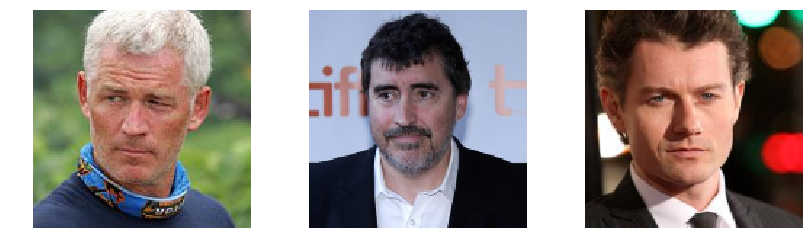

After decoding:


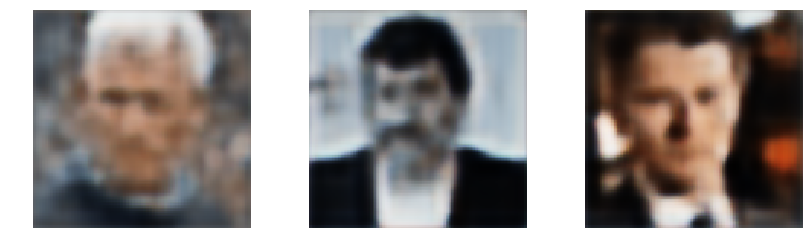

In [35]:
# Let's test it out. Run the autoencoder on our sample.
im_decoded = auto_model.predict(X_sample[:3])

print('Before autoencoding:')
plot_three(X_sample[:3])
print('After decoding:')
plot_three(im_decoded[:3])

This is pretty cool. Not much else to say about it -- we aren't going to be using the full output for anything, we've just built the model so we can pull from interior layers.

## Building an Attention Model

We'll grab the output from the last convolutional layer in the model and use that to determine where the model is paying the most attention. We can try a few different ways of pooling the filters from the internal layer -- mean, max, std. Let's look at all three.

In [19]:
# Create a function to run the initial layers of the auto_model.
get_encoded = K.function([auto_model.layers[0].input],
                     [auto_model.layers[5].output])

# Run that function on the sample set.
encoded_sample = get_encoded([X_sample])[0]

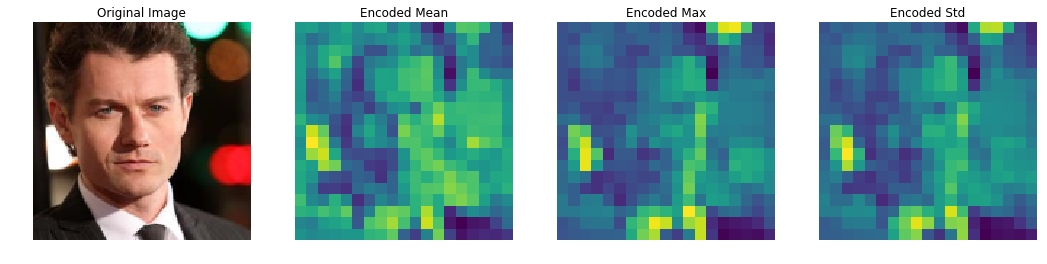

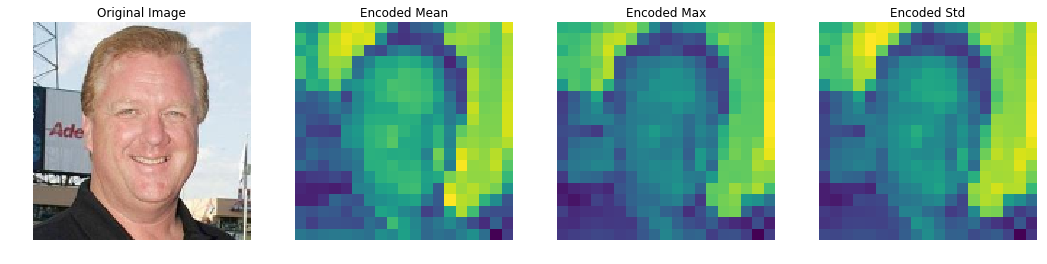

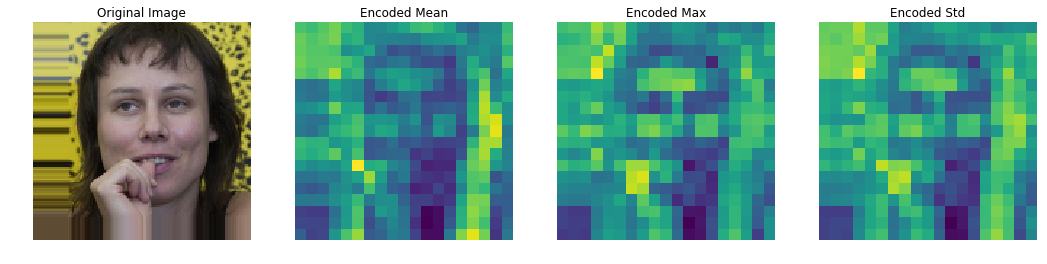

In [36]:
# Let's see what different evaluation metrics (mean, max, std) look like on the internal model filters.

for n_image in [2, 4, 6]:
    plt.figure(figsize=(18,4))

    plt.subplot(1,4,1)
    plt.imshow(X_sample[n_image][:,:,::-1])
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(encoded_sample[n_image].mean(axis=-1))
    plt.axis('off')
    plt.title('Encoded Mean')

    plt.subplot(1,4,3)
    plt.imshow(encoded_sample[n_image].max(axis=-1))
    plt.axis('off')
    plt.title('Encoded Max')

    plt.subplot(1,4,4)
    plt.imshow(encoded_sample[n_image].std(axis=-1))
    plt.axis('off')
    plt.title('Encoded Std')

    plt.show()

These are all pretty similar. The standard method for processing a convolutional layer is to take the max() of the filters. Let's stick with convention and use that method for our attention map as well.

In [37]:
# Function to pool the internal layer. Inputs are: the data, the model, and the index of the last convolutional layer.
#
# Inputs are:
#     model: a neural network with a convolutional layer
#     last_conv_layer: the numeric index of the final convolutional layer in the model
#     X_data: the data you want converted

def pool_conv_layer(model, X_data, last_conv_layer=4):
    # Run the model up until the last convolutional layer.
    get_encoded = K.function([model.layers[0].input],
                             [model.layers[last_conv_layer].output])
    encoded_array = get_encoded([X_data])[0]
    pooled_array = encoded_array.max(axis=3)
    return pooled_array

# And a function to plot those results directly.

def plot_with_attention(model, X_data, n_images, last_conv_layer=4):
    X_to_plot = X_data[np.random.choice(range(len(X_data)), n_images, replace=False)]
    pooled_array = pool_conv_layer(model, X_to_plot, last_conv_layer)
    
    plt.figure(figsize=(10, 4*n_images))
    for i in range(n_images):
        plt.subplot(n_images, 2, 2*i+1)
        plt.imshow(X_to_plot[i][:,:,::-1])
        plt.axis('off')
        plt.subplot(n_images, 2, 2*i+2)
        plt.imshow(cv2.resize(pooled_array[i], (X_to_plot.shape[1], X_to_plot.shape[2])))
        plt.axis('off')
                   
    plt.show()

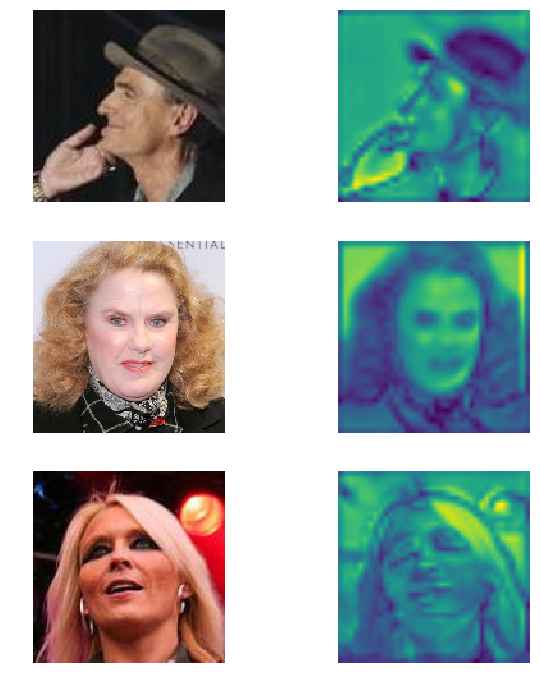

In [39]:
# Try it out!
plot_with_attention(auto_model, X_sample, 3)

The image on the right is the max of the filters of the decoded image. Bright spots are where the model is activated the most. Note that this model isn't trained on anything in particular -- it just compresses and decompresses images, and there's no reason it should give preference to the pixels on the face. We expect it to be most excited by bright things and sharp contrasts. If we ran this on a facial recognition model, we'd expect parts of the face to be the most important pixels.

## Clustering With Attention

The full images are too big and complicated to cluster effectively. Instead, we'll use the encoded versions and see what features our clustering algorithm takes into account in making its decisions. I've looked at clusters from two models with the following outputs:

    1. Internal output layer shaped (38, 38, 12). This is still too big to cluster effectively, so I pooled the layers by taking the Max of the final dimension.
    
    2. Internal output layer shaped (19, 19, 8). This is small enough to allow clustering on the full set of filter layers. The spatial resolution isn't as good, but we actually have twice as many total features to work with.
    
Ultimately, the clusters worked out better with the second method -- it turns out keeping the filter data intact was more important than spatial resolution, likely because it retains more of the color data.

In [16]:
# In case you've already saved the encoded images.
X_encoded = np.load('X_encoded.npy')

In [ ]:
# In case you've already saved the encoded images.
X_encoded_compressed = np.load('X_encoded_compressed.npy')

In [ ]:
# Again, these arrays are too large to run all at once, so we'll collect the encoded data in batches

X_encoded = []
i=0

# Iterate through the full training set.
for batch in get_batches(df_train, batch_size=1000):
    i+=1
    print('Running batch... {}'.format(i*len(batch)))
    # This line runs our pooling function on the model for each batch.
    X_encoded.append(pool_conv_layer(auto_model, process_images(batch)[0]))
    
X_encoded = np.concatenate(X_encoded)

In [42]:
# You don't want to do that multiple times...
np.save('X_encoded.npy', X_encoded)

In [ ]:
# Let's do the same thing but keep the layer information -- that is, do NOT pool it this time.

X_encoded_compressed = []
i=0
for batch in get_batches(df_train, batch_size=1000):
    i+=1
    print('Running batch... {}'.format(i*len(batch)))    
    X_encoded_compressed.append(get_encoded([process_images(batch)[0]])[0])
    
X_encoded_compressed = np.concatenate(X_encoded_compressed)

In [24]:
# Save it.
np.save('X_encoded_compressed.npy', X_encoded_compressed)

In [ ]:
# Reshape the arrays so we can run them though a clustering algorithm.
X_encoded_reshape = X_encoded.reshape(X_encoded.shape[0], 
                                      X_encoded.shape[1]*X_encoded.shape[2])
print('Encoded shape:', X_encoded_reshape.shape)

In [25]:
# Slightly different code when we're working with the smaller model dimensions.
X_encoded_compressed_reshape = X_encoded_compressed.reshape(X_encoded_compressed.shape[0], 
                                                            X_encoded_compressed.shape[1]*X_encoded_compressed.shape[2]*X_encoded_compressed.shape[3])
print('Encoded compressed shape:', X_encoded_compressed_reshape.shape)

Encoded compressed shape: (175857, 2888)


## Cluster with KMeans

Finally, we can run our clustering algorithm. Keep in mind that these encoded images are NOT focusing specifically on faces -- we may get commonalities in background, general shapes, etc, etc. 

In [26]:
# We have 175,000 examples, so no matter how many clusters we create, we'll likely have some useful ones
# and some less useful ones. 25 seems to work fairly well.
n_clusters = 25

In [ ]:
# We'll run a standard KMeans.
km = KMeans(n_clusters = n_clusters)
km.fit(X_encoded_compressed_reshape)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
# Save the model for later.
pickle.dump(km, open('km_compressed_25.sav', 'wb'))

In [24]:
# Or load it if you already ran it.
km = pickle.load(open('km_25.sav', 'rb'))

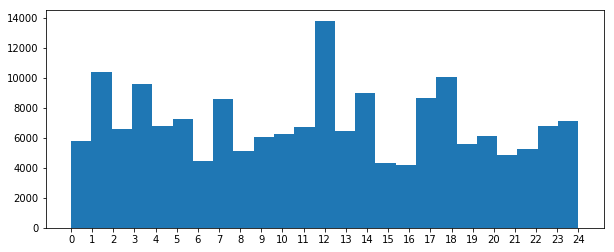

In [30]:
# How many images do each of our clusters have?
plt.figure(figsize=(10,4))
plt.hist(km.labels_, bins=n_clusters)
plt.xticks(range(n_clusters))
plt.show()

Cluster 0: 5818 Elements


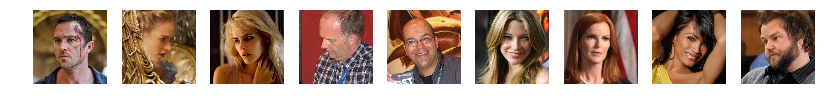

Cluster 1: 10427 Elements


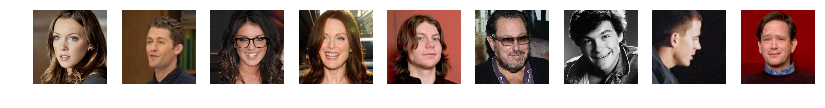

Cluster 2: 6595 Elements


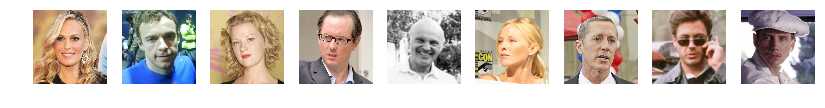

Cluster 3: 9572 Elements


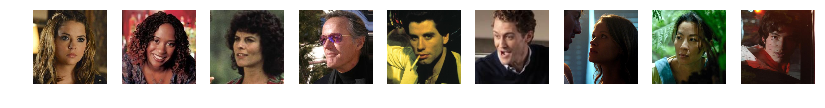

Cluster 4: 6767 Elements


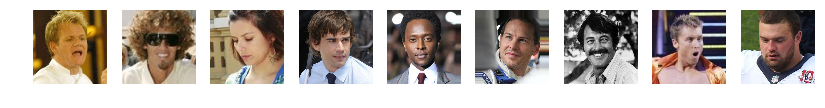

Cluster 5: 7230 Elements


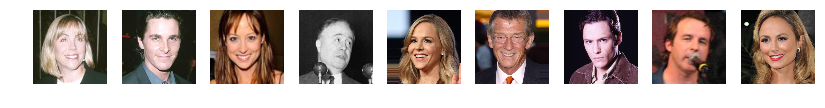

Cluster 6: 4461 Elements


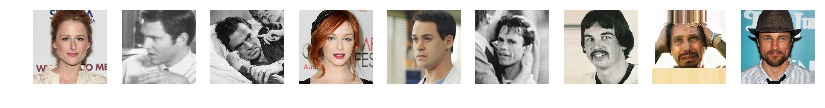

Cluster 7: 8605 Elements


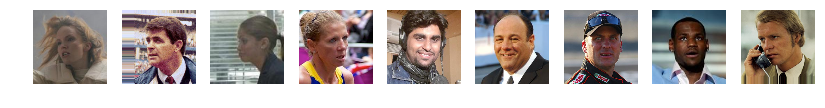

Cluster 8: 5094 Elements


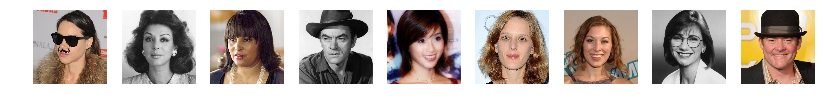

Cluster 9: 6090 Elements


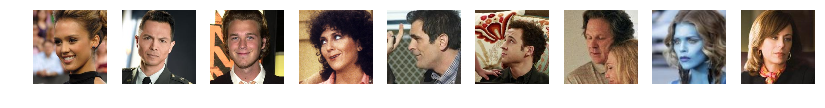

Cluster 10: 6237 Elements


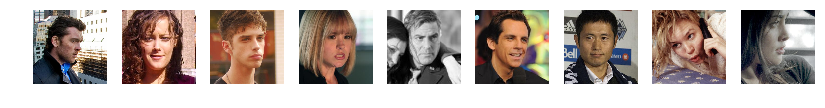

Cluster 11: 6710 Elements


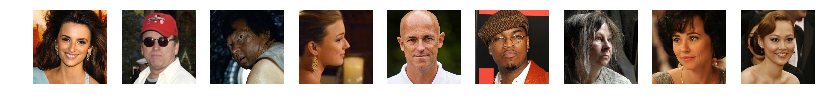

Cluster 12: 13819 Elements


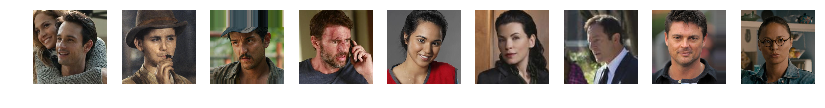

Cluster 13: 6466 Elements


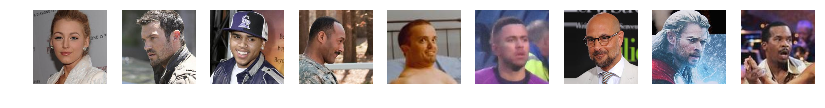

Cluster 14: 9010 Elements


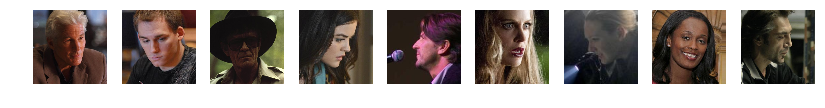

Cluster 15: 4329 Elements


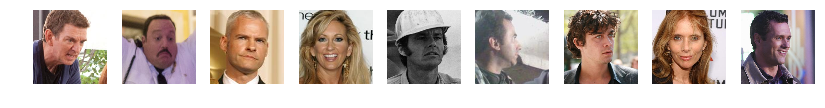

Cluster 16: 4160 Elements


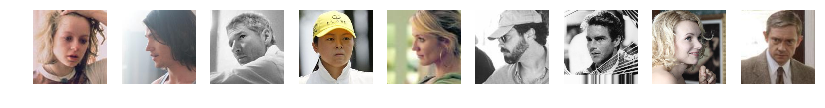

Cluster 17: 8663 Elements


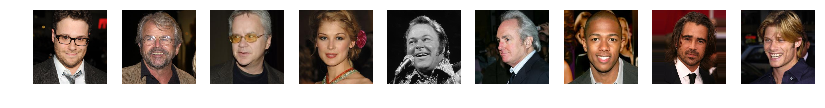

Cluster 18: 10054 Elements


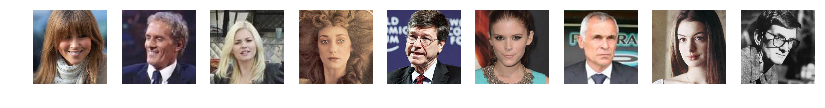

Cluster 19: 5615 Elements


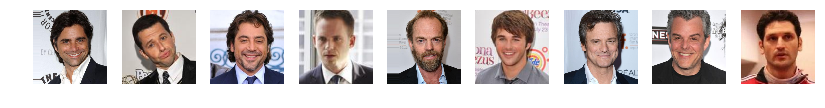

Cluster 20: 6124 Elements


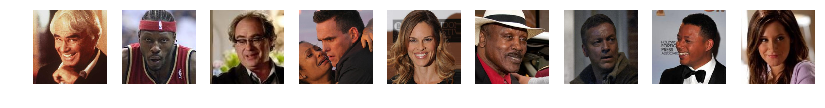

Cluster 21: 4842 Elements


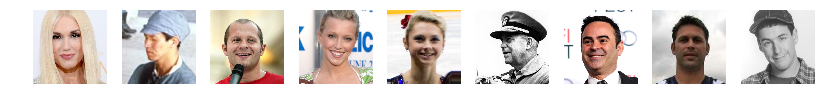

Cluster 22: 5236 Elements


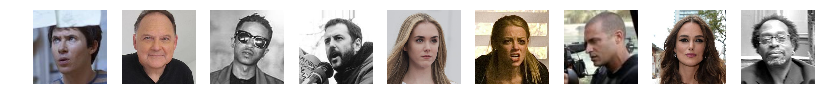

Cluster 23: 6814 Elements


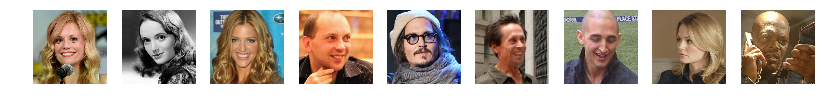

Cluster 24: 7119 Elements


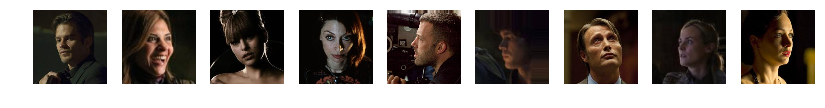

In [40]:
# Displot three images from each cluster.
for i in range(n_clusters):
    print('Cluster {}: {} Elements'.format(i, (km.labels_==i).sum()))
    plot_three(process_images(df_train.iloc[np.random.choice(np.where(km.labels_==i)[0], 9, replace=False), :])[0])

In [51]:
# Show lots of images from cluster X.

def show_lots(df, cluster_number, pages_of_images=5):
    # Grab the selection of images.
    df_selection = df.iloc[np.random.choice(np.where(km.labels_==cluster_number)[0], 9*pages_of_images, replace=False), :]
    
    # Plot 'em.
    print('Showing cluster {}'.format(cluster_number))
    for i in range(pages_of_images):
        plot_three(process_images(df_selection[i*9:(i+1)*9])[0])

Showing cluster 24


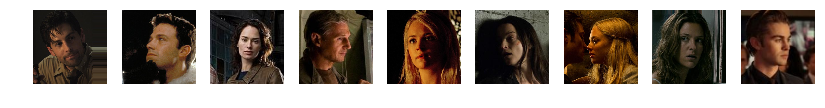

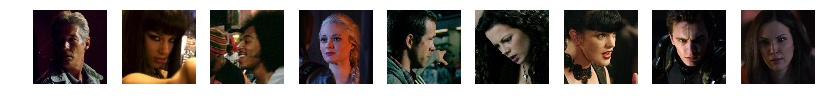

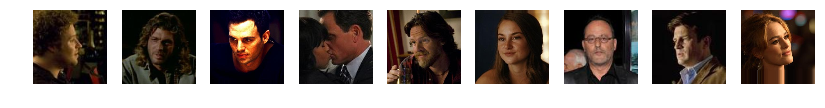

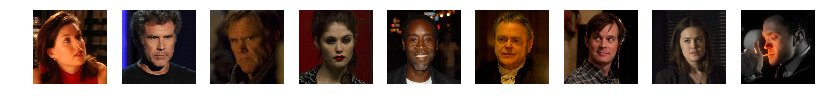

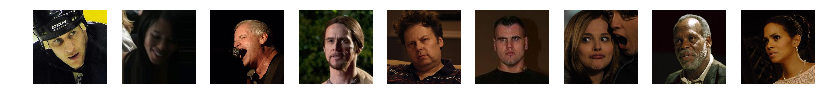

In [52]:
show_lots(df_train, 24)

This is so cool! Remember that we are clustering based on the *encoded* image, not the full image itself. Cluster 24 is full of dark images, low-lit faces. 

Showing cluster 19


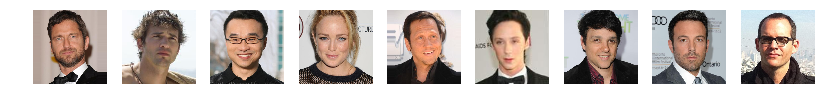

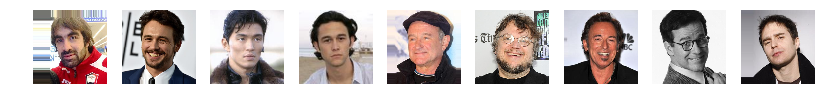

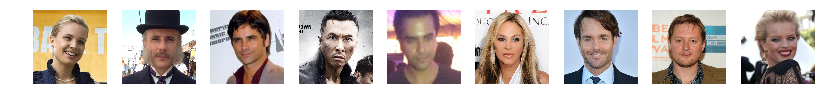

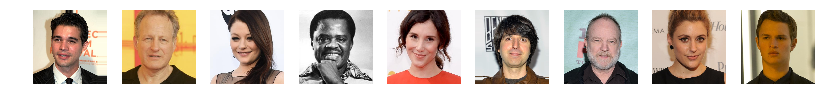

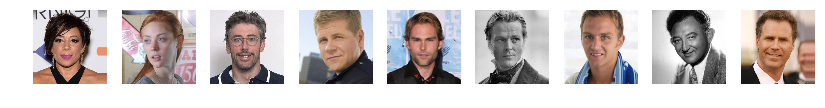

In [55]:
show_lots(df_train, 19)

Cluster 19 is primarily men with short, dark hair on light backgrounds.

Some other good ones:

    -Cluster 2: mostly blonde hair
    -Cluster 4: white shirts
    -Cluster 5: light skin on dark background
    -Cluster 8: long dark hair
    -Clusters 11 & 12: darker skin than most clusters
    -Cluster 14: long hair with dark background
    -Cluster 15: medium skin on light background
    -Cluster 17: bright face on dark background
    -Cluster 22: not much hair

## Average Cluster Images

Finally, let's look at the 'average' image from each cluster. This may give better insight into how the clusters differ, and which ones are well or poorly defined.

In [83]:
# Get the average encoded image for a cluster

# In case we've already summed over the final axis.
def get_avg_3D(array_3D):
    return array_3D.mean(axis=0)

# In case we still have all the filter information, i.e. 19x19x8.
def get_avg_4D(array_4D):
    return array_4D.mean(axis=0).mean(axis=-1)

# Average the clusters over the dimensions for each label.
def avg_cluster(data, cluster, labels=km.labels_):
    if len(data.shape)==3:
        return get_avg_3D(data[labels==cluster])
    elif len(data.shape)==4:
        return get_avg_4D(data[labels==cluster])
    else:
        print('Bad Shape')

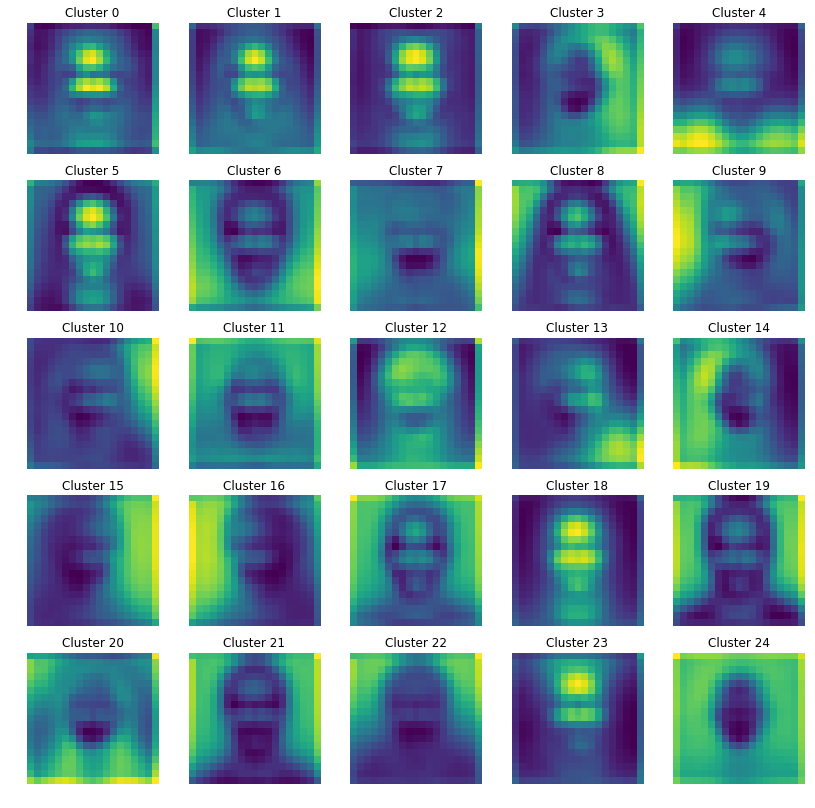

In [96]:
plt.figure(figsize=(14,14))

# Plot each cluster separately.
for i in range(n_clusters):
    plt.subplot(5, 5, i+1)
    plt.imshow(avg_cluster(X_encoded_compressed, i, labels=km.labels_))
    plt.title('Cluster {}'.format(i))
    plt.axis('off')

plt.show()

Again, so cool! This makes a lot clearer what each cluster is doing. Note that we lose all the color data here -- this in purely a measure of intesity (average over all filter layers). What if we ran these average images through the decoding process to recover those filter layers? Let's try!

In [97]:
# Function to decode our images -- this is the rest of the model from before.
get_decoded = K.function([auto_model.layers[6].input],
                         [auto_model.layers[-1].output])

In [123]:
# Build an array of the average encoded images. Should be the size of n_clusters.
average_clusters_encoded = []
for i in range(n_clusters):
    average_clusters_encoded.append(X_encoded_compressed[km.labels_==i].mean(axis=0))

average_clusters_encoded = np.asarray(average_clusters_encoded)

average_clusters_encoded.shape

(25, 19, 19, 8)

(25, 150, 150, 3)


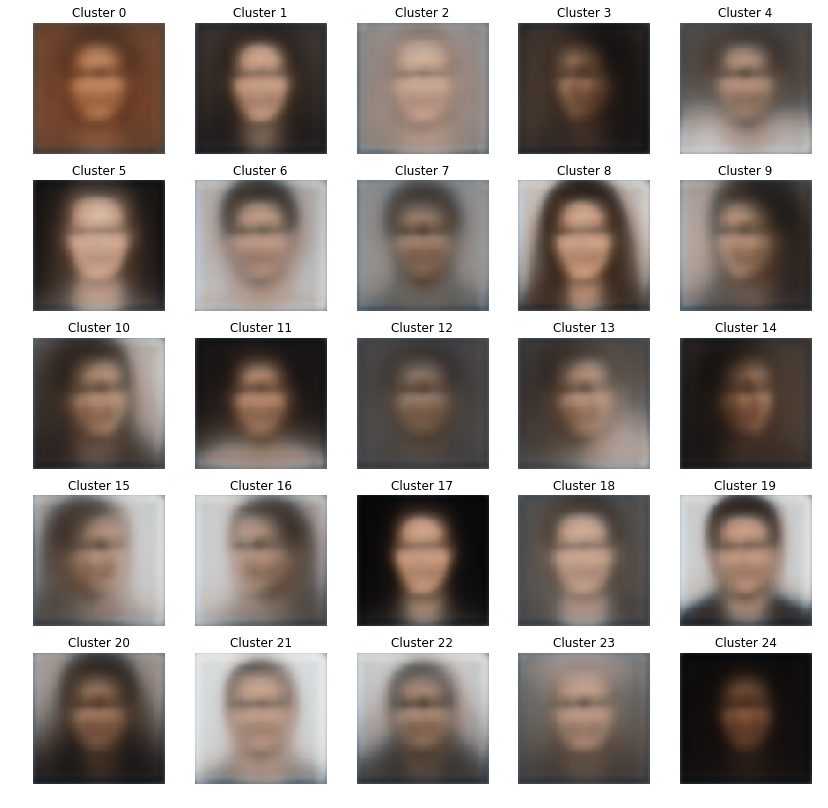

In [124]:
# Decode the average encoded arrays using the second half of our model.
decoded_clusters = get_decoded([average_clusters_encoded])

plt.figure(figsize=(14,14))

for i in range(n_clusters):
    plt.subplot(5, 5, i+1)
    plt.imshow(decoded_clusters[0][i][:,:,::-1])
    plt.title('Cluster {}'.format(i))
    plt.axis('off')

plt.show()

We did it! This is a better description of what each cluster is doing than I could have provided above. So cool. This is also starting to get into the realm of creepy and invasive -- it goes to show how easy it is for companies to build a face classifier.

# Conclusion

We've used a number of different but related approaches here to examine our face image data with convolutional neural networks. First, we tried, mostly unsuccessfully, to train our model to predict age from an image. There could be a few reasons this isn't working well. First, we may need more data. Although we had ~200,000 images, our neural net will perform better with more data. Second, we may need higher resolution images. Age tends to show via subtle cues and wrinkles, which may be mostly washed out in our 150x150 pixel images. Third, our the bulk of our data set is from IMDB, and celebrities wear a lot of make up. There's all sorts of reasons our isolated sample set could be making our model suffer. Finally, it might just be really hard to predict age. Even humans may not be able to guess a person's age within ten years from a single picture.

Next, we built an autoencoder to downsample our images. In terms of image compression, this is not a particularly useful method in the real world, however it does allow us to isolate the 'important' parts of an image (our attention map) so we can run other metrics and models on it. In this case, we used the encoded, low resolution images to serve as the input for an unsupervised clustering algorithm.

We tried several iterations of clustering, and eventually found that a lower resolution image which retained multiple filter layers seemed to produce the most distinct and stable clusters via visual inspection.  We then analyzed the clusters and found the 'average image' from each cluster. This allowed to improve our understanding of which clusters did what without having to resort to looking at large numbers of images. Because the autoencoder was not specifically designed to look at faces, we didn't necessarily expect these clusters to focus on differences in the faces more than in the pixels surrounding them, and in fact we did find that background color played a large role in clustering.

This technique of encoding images, clustering based on pared-down features, then using the raw encoded information or decoding back to something recognizable is extremely powerful and has all sorts of applications. This face classification starts to get into the world of surveillance and facial recognition. If I can do this level of classification on my own in a couple weeks, it would be trivial for a team of engineers to do substantially more.